* Convention is Master_slave.unw, and crossmul takes master*conj(slave),
* such that a negative values in the unwrapped phase corresponds to a
* subsidence (since phase=phi_1-phi_2)

* Fire began 8/13/2020, was 100% contained 12/2/20
* greatest extent by 10/18/20 ?
* Data processed was Path 56 Frame 455
* pixel spacing in dem.rsc is 15m

In [1]:
from numpy import loadtxt
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.io import savemat
import numpy as np
import util_mod
import datetime as dt
import skimage
from skimage import transform
from scipy.ndimage.filters import generic_filter
import signal
from skimage.morphology import disk
from scipy import ndimage
from scipy import signal

/var/folders/fw/x_0_bm5j7t95hlpkzx1w44j00000gn/T/ipykernel_33035/1892273724.py:10: DeprecationWarning: Please use `generic_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import generic_filter


In [2]:
#These are a bunch of variables that we have to define for the cells below. We will change these parameters for each InSAR dataset that we use

sbas_list='sbas_list_active2'#list of SBAS Interferogram pairs with scene names, temporal baseline, and spatial baseline
intlist='intlist_active2'#list of interferograms corresponding to SBAS list
geolist='geolist'#list of scene names
nr=8222 #number of pixels in range
naz=3420 #number of pixels in azimuth
n=17            #number of slcs 
Bperp_file='Bperp36.out' #matrix of (spatial) perpendicular baseline values
Tm_file='Tm36.out' #matrix of temporal baseline values
deltime_file='deltime36.out' #matrix of delta time values
timedeltas_file='timedeltas36.out'
wvl=0.0554 #wavelength of radar (C band for Sentinel)
skew_val=0.4 #Skewness value for thresholding good and bad data
#r_ref=[298, 186, 230, 245, 47]   #  reference pixel location
#az_ref=[143, 176, 47, 540, 295]  #  reference pixel location

In [3]:
#Step 1.
#1a. Read in all InSAR data (.unw unwrapped interferograms, .cc coherence files)
#1b. Read in ancillary files (list files, SBAS matrices)

print('Reading in InSAR data and SBAS Ancillary files')
f = open(sbas_list,'r')
sbas_pairs = []
for line in f:
    sbas_pairs.append(line.strip())
f.close()

f = open(intlist,'r')
int_pairs = []
for line in f:
    int_pairs.append(line.strip())
f.close()

f = open(geolist,'r')
geos = []
for line in f:
    geos.append(line.strip())
f.close()
N_geo=len(geos)


#Read in Bperp info
lines=[]
with open(Bperp_file, 'r') as fileobj:
    for row in fileobj:
        line=row.rstrip('\n')
        lines.append(float(line))
Bperp=np.asarray(lines)
N_int=Bperp.size

#Read in time information
count1=[]
dtime_ints1=[]
time11=[]
time21=[]
with open(deltime_file, 'r') as fileobj:
    for row in fileobj:
        line=row.rstrip('\n')
        line_vals=line.split(' ')
        count1.append(float(line_vals[0]))
        dtime_ints1.append(float(line_vals[1]))
        time11.append(float(line_vals[2]))
        time21.append(float(line_vals[3]))
count=np.asarray(count1)
dtime_ints=np.asarray(dtime_ints1)
time1=np.asarray(time11)
time2=np.asarray(time21)
dtime_scenes_list=[]
with open(timedeltas_file, 'r') as fileobj:
    for row in fileobj:
        line=row.rstrip('\n')
        dtime_scenes_list.append(float(line))
dtime_scenes=np.asarray(dtime_scenes_list)
N_scene=dtime_scenes.size+1
geo_dates=[]
geo_doys=[]
for (i,geo) in enumerate(geos):
	d1=geo[20:28]
	year1=d1[0:4]
	month1=d1[4:6]
	day1=d1[6:8]
	doy1 = (dt.date(int(year1), int(month1), int(day1)) - dt.date(int(year1),1,1)).days + 1
	geo_dates.append(str(day1))
	geo_doys.append(int(doy1))



#Read in Tm matrix as array N_int by N_scene
Tm1=[]
with open(Tm_file, 'r') as fileobj:
    for row in fileobj:
        line_vals=row.rstrip('\n')
        #line_vals=line.split(' ')
        #Tm1.append(line_vals[0:(N_scene-1)])
        Tm1.append(line_vals)
Tm0=np.asarray(Tm1)
Tm2=np.zeros((N_int,N_scene-1))
for i in range(N_int):
	line=Tm0[i]
	line_vals=line.split(' ')
	for j in range(N_scene-1):
		Tm2[i,j] = float(line_vals[j])
Tm=np.copy(Tm2)


#Read in interferograms, unwrapped interferograms, coherence, and amplitude files
unw_phase=np.zeros((int(naz),int(nr),int(N_int)))
amp=np.zeros((int(naz),int(nr),int(N_int)))
coh=np.zeros((int(naz),int(nr),int(N_int)))
ints=np.zeros((int(naz),int(nr),int(N_int)))
date_pairs=[]
doy_pairs=[]
for (i,int_pair) in enumerate(int_pairs):
    strunw1=int_pair.replace('.int','.unw')
    stramp1=int_pair.replace('.int','.amp')
    strcc1=int_pair.replace('.int','.cc')
    strint1=int_pair

    strunw='unws/'+str(strunw1)
    strint='ints/'+str(strint1)
    stramp='amps/'+str(stramp1)
    strcc='ccs/'+str(strcc1)


    (amp,unw)=util_mod.read_hgt_file(strunw,nr)
    (amp,cor)=util_mod.read_hgt_file(strcc,nr)
    #(amp,amp1)=util_mod.read_hgt_file(stramp,nr)
    #(amp,int1)=util_mod.read_cpx_file(strint,nr)

    unw_phase[:,:,i] = unw
    coh[:,:,i] = cor
    #amp[:,:,i] = amp1
    #ints[:,:,i] = int1

    split1=int_pair.split('_')
    d1=split1[0]
    strint2=split1[1]
    split2=strint2.split('.')
    d2=split2[0]

    year1=d1[0:4]
    month1=d1[4:6]
    day1=d1[6:8]
    year2=d2[0:4]
    month2=d2[4:6]
    day2=d2[6:8]

    doy1 = (dt.date(int(year1), int(month1), int(day1)) - dt.date(int(year1),1,1)).days + 1
    doy2 = (dt.date(int(year2), int(month2), int(day2)) - dt.date(int(year2),1,1)).days + 1

    date_pair=[d1,d2]
    doy_pair=[doy1,doy2]
    date_pairs.append(date_pair)
    doy_pairs.append(doy_pair)

print('Calculating Scenewide Average Coherence')
avecc=np.mean(coh,axis=2)
cor_mask=np.copy(avecc)
cor_mask[cor_mask<0.5]=np.nan
cor_mask[cor_mask>0.5]=1

phase_cal=np.copy(unw_phase)

print('Writing out all data  as sbas_step1.mat')
#savemat('sbas_step1.mat', {'phase_cal1': phase_cal,'avecc': avecc,'cor_mask': cor_mask, 'Tm1': Tm2, 'Bperp1': Bperp,'dtime_scenes': dtime_scenes,'dtime_ints': dtime_ints,'geo_doys': geo_doys,'date_pairs': date_pairs,'doy_pairs': doy_pairs})
print('data successfully written')


Reading in InSAR data and SBAS Ancillary files
Calculating Scenewide Average Coherence
Writing out all data  as sbas_step1.mat
data successfully written


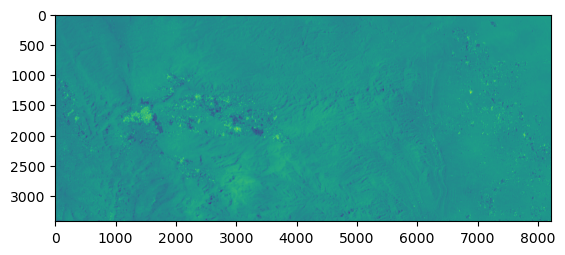

In [4]:
## Now we will do the atmospheric correction
# remove topographically-correlated atmospheric noise from interferograms
# Depending on how large the scene is, you may want to base the correction
# solely on a few areas with the topographic relief changes quite a bit.
# But if the scene is small, you can indeed use the whole scene.
# This bit also requires a calibration pixel (or set of pixels) to ensure
# that all of the scenes are set to the same "datum"

# Load the dem
nr0=24667
naz0=10261
dem0=util_mod.read_int_file('elevation.dem',nr0)
dem  = skimage.transform.resize(dem0,(naz, nr))

masked_unw_phase = np.copy(unw_phase)#.*mask;
phase = np.zeros((int(naz),int(nr),int(N_int)))
phase1 = np.zeros((int(naz),int(nr),int(N_int)))
corrections=np.zeros((int(naz),int(nr),int(N_int)))

plt.imshow(dem)

for i in range(N_int):
    block_phase = masked_unw_phase[:,:,i]
    indx = np.isnan(block_phase)
    line = np.polyfit(dem[~indx],block_phase[~indx],1)
    correction = np.multiply(line[0],dem) + line[1]
    corrections[:,:,i]=correction
    phase[:,:,i] = masked_unw_phase[:,:,i] - correction
    
    
plt.imshow(phase[:,:,4])   

In [5]:
## Pluck out Scenes you want to use, only use scenes that satisfy a skewness criteria
scene_inds=np.linspace(1,N_int,N_int)
Ngood=len(scene_inds)
phase_good=np.copy(phase)
coh_good = np.copy(coh)
doy_pair_good=np.copy(doy_pair)

In [6]:
phase_good_std= np.zeros((int(naz),int(nr),int(N_int)))
coh_good_std= np.zeros((int(naz),int(nr),int(N_int)))
phase_good_mean= np.zeros((int(naz),int(nr),int(N_int)))
coh_good_mean= np.zeros((int(naz),int(nr),int(N_int)))

In [ ]:
## Phase Standard Deviation

h = np.divide(np.ones((11,1)),11)
H = np.matmul(h,h.T)

for i in range(Ngood):
    print(i)
    phase_good_std[:,:,i] = generic_filter(phase_good[:,:,i], np.std, size=11)
    coh_good_std[:,:,i] = generic_filter(coh_good[:,:,i], np.std, size=11)
    phase_good_mean[:,:,i] = signal.convolve2d(phase_good[:,:,i], np.rot90(H))
    coh_good_mean[:,:,i] = signal.convolve2d(coh_good[:,:,i], np.rot90(H))

0


In [ ]:
phase_good_std2=np.copy(phase_good_std)
val=np.pi/np.sqrt(3)
print(val)


phase_good_std2[phase_good_std2<val]=0
phase_good_std2[phase_good_std2>=val]=1
se = disk(10)


#4489 corresponds to ~ 1km square area
for i in range(Ngood):
    opened[:,:,i]=ndimage.binary_opening(phase_good_std2[:,:,i], structure=np.ones((67,67))).astype(int)

In [ ]:
    
#std filter mask
test=np.var(opened,2)
test_mask=np.copy(test)
test_mask[test_mask>0.12]=1
test_mask[test_mask<0.12]=0


bounding_mask=np.ones((nr,naz))
bounding_mask[1:915,:]=np.nan
bounding_mask[5906:end,:]=np.nan

bounding_mask[1500:2250,1:400]=np.nan
bounding_mask[1:1600,1:900]=np.nan
bounding_mask[1:500,1600:2400]=np.nan
bounding_mask[600:1950,2660:end]=np.nan
bounding_mask[1930:2300,2875:end]=np.nan

masked_opened=np.multiply(np.multiply(bounding_mask,test_mask),opened)
masked_opened1=np.copy(masked_opened)
masked_opened1[np.isnan(masked_opened1)]=0

In [ ]:
masked_opened[masked_opened==0]=np.nan
masked_phase=np.multiply(np.multiply(np.multiply(bounding_mask,test_mask),opened),phase_good)
masked_phase[masked_phase==0]=np.nan
masked_std=np.multiply(np.multiply(np.multiply(bounding_mask,test_mask),opened),phase_good_std)
masked_std[masked_std==0]=nan
masked_coh=np.multiply(np.multiply(np.multiply(bounding_mask,test_mask),opened),coh_good)
masked_coh[masked_coh==0]=np.nan


for i in range(N):
    masked_phase_mean[i]=np.nanmean(np.nanmean(masked_phase[:,:,i]))
    masked_std_mean[i]=np.nanmean(np.nanmean(masked_std[:,:,i]))

    
    

# get converse map, all non fire pixels
total_fire_map=np.multiply(np.multiply(bounding_mask,test_mask),opened)
total_fire_map[np.isnan(total_fire_map)]=0
nonfire_map=np.ones((nr,naz))-total_fire_map
nonfire_map[isnan(nonfire_map)]=0

masked_nonfire_coh=np.multiply(nonfire_map,coh_good)

In [ ]:
## 'SBAS' for Fire Burn Area new
#save descending_masked_opened masked_opened -v7.3

I=np.copy(masked_opened)
I[np.isnan(I)]=0

I2=np.copy(I[:,:,0:12])

#a is 8 x 1
a=np.zeros((size(I2,1),size(I2,2),8))
#B is 14 x 8, #ints x #scenes
B=np.zeros((13,8))
B[1,1]=1
B[2,1]=1
B[3,2]=1
[B4,2]=1
B[5,2]=1
B[6,3]=1
B[7,4]=1
B[8,2]=1
B[9,3]=1
B[10,4]=1
B[11,5]=1
B[12,5]=1
B[13,6]=1
#B[14,7]=1

B[1,2]=-1
B[2,3]=-1
B[3,3]=-1
B[4,4]=-1
B[5,5]=-1
B[6,5]=-1
B[7,5]=-1
B[8,6]=-1
B[9,6]=-1
B[10,6]=-1
B[11,6]=-1
B[12,8]=-1
B[13,8]=-1
#B[14,8]=-1


#B[14,:]=0
#B[:,7]=0

Bi=np.pinv(np.multiply(-1,B))

for i in range(size(I,0)):
    for j in range(size(I,1)):
        pluck=np.squeeze(I2[i,j,:])
        out=np.matmul(Bi,pluck)
        a[i,j,:]=out

# a_filt2=np.copy(a)
# a_filt2[a_filt2<0]=0
# a_2=a_np.copy(filt2)
# a_2[a_2>0]=1


a_filt=np.copy(a)
a_filt[a_filt<0]=0
filt_val=np.sum(np.abs(B))
a_1=np.zeros(size(a_filt))

for i in range(len(filt_val)):
    pluck=a_filt[:,:,i]
    val=np.divide(0.25,filt_val[i])
    pluck[pluck<val]=0
    pluck[pluck>=val]=1
    a_1[:,:,i]=pluck

In [ ]:
## ascending 'SBAS' for Fire Burn Area new
#load ascending_masked_opened.mat

I=np.copy(ascending_masked_opened)
I[isnan(I)]=0
I2=np.copy(I)
#a is 8 x 1
a=np.zeros((size(I2,1),size(I2,2),9))
#B is 14 x 8, #ints x #scenes
B=np.zeros((18,9))
B[1,1]=1
B[2,3]=1
B[3,1]=1
B[4,2]=1
B[5,3]=1
B[6,4]=1
B[7,5]=1
B[8,3]=1
B[9,4]=1
B[10,5]=1
B[11,6]=1
B[12,4]=1
B[13,5]=1
B[14,6]=1
B[15,5]=1
B[16,6]=1
B[17,7]=1
B[18,8]=1

h=-1
B[1,4]=h
B[2,4]=h
B[3,5]=h
B[4,6]=h
B[5,6]=h
B[6,6]=h
B[7,6]=h
B[8,7]=h
B[9,7]=h
B[10,7]=h
B[11,7]=h
B[12,8]=h
B[13,8]=h
B[14,8]=h
B[15,9]=h
B[16,9]=h
B[17,9]=h
B[18,9]=h


#B[14,:]=0
#B[:,7]=0
#B=B[3:14,1:end]
#Bi=np.pinv[B]
Bi=np.pinv(np.multipy(-1,B))
#I2=I[:,:,3:14]
#a=a[:,:,1:end]


for i in range(size(I,0)):
    for j in range(size(I,1)):
        pluck=np.squeeze(I2[i,j,:])
        out=np.matmul(Bi,pluck)
        a[i,j,:]=out

a_filt=np.copy(a)
a_filt[a_filt<0]=0
filt_val=np.sum(np.abs(B))
a_2=np.zeros(size(a_filt))

for i in range(len(filt_val)):
    pluck=a_filt[:,:,i]
    val=np.divide(1.5,filt_val[i])
    pluck[pluck<val]=0
    pluck[pluck>=val]=1
    a_2[:,:,i]=pluck

ascending_map = np.zeros((nr,naz,n))
ascending_map[:,:,5]=a_2[:,:,4]
ascending_map[:,:,6]=a_2[:,:,5]
ascending_map[:,:,7]=a_2[:,:,6]
ascending_map[:,:,8]=a_2[:,:,7]
ascending_map[:,:,9]=a_2[:,:,8]
ascending_map[:,:,10]=a_2[:,:,9]

In [ ]:
##  Do Map Progression
total_map=np.zeros((nr,naz,33))
total_map[:,:,4]=a_1[:,:,1]                  #07/21
total_map[:,:,8]=a_1[:,:,2]                  #08/14
total_map[:,:,9]=ascending_map[:,:,5]        #08/22
total_map[:,:,10]=a_1[:,:,3]                 #08/26
total_map[:,:,11]=ascending_map[:,:,6]       #09/03
total_map[:,:,12]=a_1[:,:,4]                 #09/07
total_map[:,:,13]=ascending_map[:,:,7]       #09/15
total_map[:,:,14]=a_1[:,:,5]                 #09/19
total_map[:,:,15]=ascending_map[:,:,8]       #09/27
total_map[:,:,16]=a_1[:,:,6]                 #10/01
total_map[:,:,17]=ascending_map[:,:,9]       #10/09
total_map[:,:,18]=a_1[:,:,7]                 #10/13
total_map[:,:,19]=ascending_map[:,:,10]      #10/21
total_map[:,:,21]=a_1[:,:,8]                 #11/06

total_map[total_map==0]=np.nan

In [ ]:
[A geoR]=geotiffread('20200709_20200919.tif')
cellsNN=importdata('total_dates')

#view time series
#figure('units','normalized','outerposition',[0 0 1 1]);
for i in range(33):
    st='view_time_step_descending_'+str(i)+'_date_'+str(geo_dates[i])
    geotiffwrite(st,total_map[:,:,i].T,geoR)


i=4
geotiffwrite('coherence_example_'+str(i)+'.tif',coh_good[:,:,i].T,geoR)
geotiffwrite('phase_example_'+str(i)+'.tif',phase_good[:,:,i].T,geoR)
geotiffwrite('phase_std_example_'+str(i)+'.tif',phase_good_std[:,:,i].T,geoR)

geotiffwrite('test.tif',phase_good_std[:,:,i].T,geoR)

In [ ]:
## Let's estimate the first order interferometric phase variance from Bamler and Hartl
#coh_vec=0:0.1:1;

#sig_var = (pi*pi/3) - pi*asin(abs(coh_vec)) + (asin(abs(coh_vec))).^2 - 0.5*dilog((abs(coh_vec)).^2);

#sig_var = (pi*pi/3) - pi*asin(abs(coh_vec)) + (asin(abs(coh_vec))).^2 - 0.5*polylog(2,(abs(coh_vec)).^2);


#plot((pi*pi/3)*ones(length(coh_vec),1))
#hold on
#plot(-1.*pi*asin(abs(coh_vec)))
#hold on
#plot((asin(abs(coh_vec))).^2)
#hold on
#plot(-0.5*dilog((abs(coh_vec)).^2))
